In [1]:
# ---- Cleanup everything before start ----
options(warn=-1)
rm(list = ls())
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,446475,23.9,750400,40.1,592000,31.7
Vcells,866874,6.7,1530645,11.7,1052706,8.1


In [2]:
### Find true capital-state pairs from all possible capital-state pairs

# ---- GBSERVER API ----
source("./Rscript/experimentAPI.R")
# ---- INPUT and CONFIGURATIONS ----

EDGE_TYPE_FILE = "./data/infobox.edgetypes" # Example : "../data/lobbyist.edgetypes"
CLUSTER_SIZE = 4 # Number of workers in gbserver
FALSE_PER_TRUE = 5
DISCARD_REL = 191
ASSOCIATE_REL = c(404)
max_depth = 3

# ---- Load edge type file ----
mapfile <- read.csv(EDGE_TYPE_FILE, sep="\t", header=F)
mapfile$V1 <- as.numeric(mapfile$V1)
mapfile$V2 <- as.character(mapfile$V2)

In [3]:
list.of.packages <- c("bear", "FSelector", "ggplot2")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos="http://cran.rstudio.com/")
library(FSelector)
library(ggplot2)


In [5]:
# ---- Load input data ----
INPUT_FILE = "./data_id/state_capital.csv" # Example : "../facts/lobbyist/firm_payee.csv" col 1 and 2 are ids and 3 is label
dat_state_capital.true <- read.csv(INPUT_FILE)

if (ncol(dat_state_capital.true) < 3)
  dat_state_capital.true$label <- T

# ---- Construct false labeled data -----
set.seed(233)

# TODO: reformat this so it is universal and file independent
dat_state_capital.false <- rbind.fill(apply(dat_state_capital.true, 1, function(x){
  candidates <- unique(dat_state_capital.true[which(dat_state_capital.true[,1] != x[1]), 2])
  candidates <- unlist(lapply(candidates, function(y){
    if(length(which(dat_state_capital.true[,1] == x[1] & dat_state_capital.true[,2] == y) != 0)) {
      return(NULL)
    }
    return(y)
  }))
  return(data.frame(src=x[1], 
                    dst=sample(candidates, FALSE_PER_TRUE),
                    label=F))
}))

colnames(dat_state_capital.true) <- c("src","dst","label")
dat_state_capital <- rbind(dat_state_capital.true, dat_state_capital.false)


In [7]:
# ---- Init workers ----
cl <- makeCluster(CLUSTER_SIZE) 
clusterExport(cl = cl, varlist=c("adamic_adar", "semantic_proximity", "ppagerank", "heter_path",  "max_depth",
                                 "preferential_attachment", "katz", "pcrw", "heter_full_path", "meta_path",
                                 "multidimensional_adamic_adar", "heterogeneous_adamic_adar",
                                 "connectedby", "rel_path", "truelabeled", "falselabeled", "str_split",
                                 "as.numeric", "request","DISCARD_REL"), envir = environment())

In [9]:
# Find discriminative paths
tmp.paths <- rbind.fill(parApply(cl, dat_state_capital, 1, function(x) {
  tmp_paths <- rel_path(as.numeric(x[1]), as.numeric(x[2]), max_depth = 3, F, DISCARD_REL)
  if(length(tmp_paths) == 0) {
    return(data.frame(label = as.logical(x[3])))
  }
  rtn <- as.data.frame(t(tmp_paths$Freq))
  colnames(rtn) <- tmp_paths$paths
  rtn <- cbind(label = as.logical(x[3]), rtn)
  return(rtn)
}))
tmp.paths[is.na(tmp.paths)] <- 0



ERROR: Error in checkForRemoteErrors(val): 4 nodes produced errors; first error: missing value where TRUE/FALSE needed


In [79]:
tmp.paths

label,"-40,39,","-38,38,","-46,46,","-39,240,","-17,17,","-38,46,","-38,103,","-115,16,","-39,39,",⋯,"-17,212,","-200,16,","-38,86,","-38,87,","-85,86,","-85,87,","-69,39,","-46,451,","-103,184,","-104,46,"
TRUE,20,17,12,8,7,7,6,5,5,⋯,0,0,0,0,0,0,0,0,0,0
TRUE,3,8,2,0,13,1,1,0,2,⋯,0,0,0,0,0,0,0,0,0,0
TRUE,55,61,14,2,48,1,2,1,7,⋯,0,0,0,0,0,0,0,0,0,0
TRUE,28,59,37,3,24,15,13,0,4,⋯,0,0,0,0,0,0,0,0,0,0
TRUE,31,71,13,2,45,5,7,2,9,⋯,0,0,0,0,0,0,0,0,0,0
TRUE,29,188,66,8,84,11,4,1,8,⋯,0,0,0,0,0,0,0,0,0,0
TRUE,13,70,22,0,20,9,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
TRUE,4,10,24,2,4,24,27,1,3,⋯,0,0,0,0,0,0,0,0,0,0
TRUE,43,14,12,1,38,3,0,0,4,⋯,0,0,0,0,0,0,0,0,0,0
TRUE,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [101]:
res_capital_state <- list()
res_capital_state[["raw"]] <- tmp.paths
# write.csv(colnames(res[["raw"]]), "/data/bshi/dbpedia/gngm_celf.fullpath.csv")
res_capital_state[["model"]] <- Logistic(label~.,res_capital_state[["raw"]])
res_capital_state[["eval"]] <- evaluate_Weka_classifier(res_capital_state[["model"]], numFolds = 10, complexity = T, class = T, seed = 233)

In [81]:
q()

In [102]:
res_capital_state[["eval"]]

=== 10 Fold Cross Validation ===

=== Summary ===

Correctly Classified Instances         299               99.6667 %
Incorrectly Classified Instances         1                0.3333 %
Kappa statistic                          0.9879
K&B Relative Info Score              28968.5641 %
K&B Information Score                  189.9418 bits      0.6331 bits/instance
Class complexity | order 0             195.016  bits      0.6501 bits/instance
Class complexity | scheme               21.7656 bits      0.0726 bits/instance
Complexity improvement     (Sf)        173.2504 bits      0.5775 bits/instance
Mean absolute error                      0.0081
Root mean squared error                  0.0635
Relative absolute error                  2.9071 %
Root relative squared error             17.0297 %
Total Number of Instances              300     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 1.

In [103]:
# ---- Feature selection validation ----
weights_capital_state <- information.gain(label~., res_capital_state[["raw"]])
weights_capital_state <- weights_capital_state[order(weights_capital_state[,1], decreasing = T),,drop=F]

# ---- Top related relations ----
features_captial_state <- data.frame(importance=weights_capital_state$attr_importance, path=row.names(weights_capital_state))

features_captial_state <- features_captial_state[order(-features_captial_state$importance),]
features_captial_state$path <- idpath2title(features_captial_state$path, mapfile)
head(features_captial_state)


In [111]:
# ---- AOROC of predicated sub paths ----
fm_val <- function(resdf) {
  return(as.numeric(str_split(str_split(resdf$eval$string,"\n")[[1]][24], " +")[[1]][9]))
}
full_predicated_path <- res_capital_state[["raw"]]
cl <- makeCluster(5) 
clusterExport(cl = cl, varlist=c("full_predicated_path", "weights_capital_state", "eval.df", "cutoff.k", "fm_val","str_split",
                               "as.numeric"), envir = environment())
res_AOROC <- rbind.fill(parLapply(cl, seq(1,ncol(full_predicated_path)-1,by = 1), function(x){
library(FSelector)
library(RWeka)
wekares<-eval.df(full_predicated_path[,c("label", cutoff.k(weights_capital_state, x))])
return(data.frame(AOROC=fm_val(wekares),nfeature=x))
}))
stopCluster(cl)

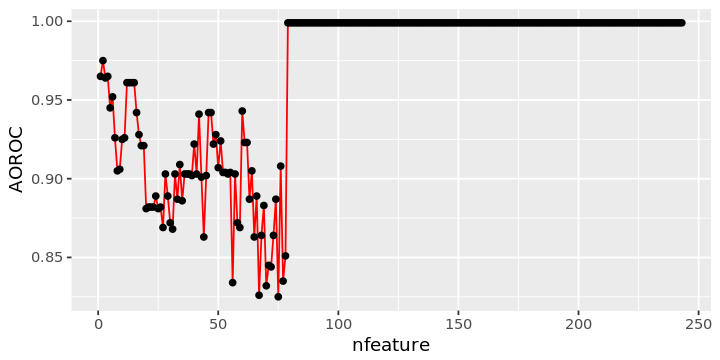

In [115]:
library(repr)
options(repr.plot.width=6, repr.plot.height=3)
ggplot(data=res_AOROC, aes(x=nfeature, y=AOROC, group=1)) +
  geom_line(color="red")+
  geom_point()

In [100]:
str_split(str_split(wekares$eval$string,"\n")[[1]][24]," +")[[1]][9]

[1] "0.881"

In [34]:
INPUT_FILE = "./data_id/country_captial.csv" # Example : "../facts/lobbyist/firm_payee.csv" col 1 and 2 are ids and 3 is label
# ---- Load input data ----
dat_2.true <- read.csv(INPUT_FILE)

if (ncol(dat_2.true) < 3)
  dat_2.true$label <- T

# ---- Construct false labeled data -----
set.seed(233)

colnames(dat_2.true) <- c("src","dst","label")


In [35]:
dat_captial_country_state <- rbind(dat_2.true[13:23,], dat)

In [38]:
res_captitals <- list()
# Find discriminative paths
capitals.paths <- rbind.fill(parApply(cl, dat_captial_country_state, 1, function(x) {
  tmp_paths <- rel_path(as.numeric(x[1]), as.numeric(x[2]), max_depth = 3, F, DISCARD_REL)
  if(length(tmp_paths) == 0) {
    return(data.frame(label = as.logical(x[3])))
  }
  rtn <- as.data.frame(t(tmp_paths$Freq))
  colnames(rtn) <- tmp_paths$paths
  rtn <- cbind(label = as.logical(x[3]), rtn)
  return(rtn)
}))
capitals.paths[is.na(capitals.paths)] <- 0

In [39]:
res_captitals[["raw"]] <- capitals.paths
# write.csv(colnames(res[["raw"]]), "/data/bshi/dbpedia/gngm_celf.fullpath.csv")
res_captitals[["model"]] <- Logistic(label~.,res_captitals[["raw"]])
res_captitals[["eval"]] <- evaluate_Weka_classifier(res_captitals[["model"]], numFolds = 10, complexity = T, class = T, seed = 233)

In [41]:
res_captitals[["eval"]]

=== 10 Fold Cross Validation ===

=== Summary ===

Correctly Classified Instances         309               99.3569 %
Incorrectly Classified Instances         2                0.6431 %
Kappa statistic                          0.9794
K&B Relative Info Score              29922.8216 %
K&B Information Score                  215.1697 bits      0.6919 bits/instance
Class complexity | order 0             222.125  bits      0.7142 bits/instance
Class complexity | scheme               60.0579 bits      0.1931 bits/instance
Complexity improvement     (Sf)        162.0671 bits      0.5211 bits/instance
Mean absolute error                      0.0099
Root mean squared error                  0.0826
Relative absolute error                  3.1251 %
Root relative squared error             20.8131 %
Total Number of Instances              311     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 1.

In [59]:
# ---- Feature selection validation ----
weights_capital_country_state <- information.gain(label~., res_captitals[["raw"]])
weights_capital_country_state <- weights_capital_country_state[order(weights_capital_country_state[,1], decreasing = T),,drop=F]

In [53]:
write.table(dat, "/home/phi/KGMiner/input_cpp.txt", sep="\t", row.names = FALSE,col.names = FALSE)
colnames(data)


NULL

In [7]:
library(utils)
library(stringr)
  
command <- paste("hpath", dat[1,1], dat[1,2], DISCARD_REL, 3, "F", "P", sep=" ")
paths <- request(command)

In [7]:
paths <- paths[-1]

In [8]:
paths <- unlist(paths[!sapply(paths, is.null)])

In [10]:
paths <- as.data.frame(table(paths))

In [16]:
paths <- paths[order(-paths$Freq),]


In [17]:
t(paths$Freq)

20,17,12,8,7,7,6,5,5,5,⋯,1,1,1,1,1,1,1,1,1,1


In [18]:
rtn <- as.data.frame(t(paths$Freq))

In [19]:
rtn

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37
20,17,12,8,7,7,6,5,5,5,⋯,1,1,1,1,1,1,1,1,1,1


In [21]:
colnames(rtn) <- paths$paths

In [22]:
rtn

"-40,39,","-38,38,","-46,46,","-39,240,","-17,17,","-38,46,","-38,103,","-115,16,","-39,39,","-46,38,",⋯,"-277,38,","-38,85,","-40,-44,","-40,404,","-40,606,","-40,72,","-40,73,","-44,","-65,38,","29,-29,"
20,17,12,8,7,7,6,5,5,5,⋯,1,1,1,1,1,1,1,1,1,1


In [23]:
rtn <- cbind(label = as.logical(F), rtn)

In [24]:
rtn

label,"-40,39,","-38,38,","-46,46,","-39,240,","-17,17,","-38,46,","-38,103,","-115,16,","-39,39,",⋯,"-277,38,","-38,85,","-40,-44,","-40,404,","-40,606,","-40,72,","-40,73,","-44,","-65,38,","29,-29,"
FALSE,20,17,12,8,7,7,6,5,5,⋯,1,1,1,1,1,1,1,1,1,1


In [25]:
dat[1,1]

[1] 221

In [26]:
dat[1,2]

[1] 10387

In [18]:
command <- paste("same_ontology", 2489, "T")
src_ontology <- request(command)
src_ontology

[1] "Tasmania,California,Nordreisa,Arkansas,Pulaski_County,_Arkansas,Louisiana,West_Feliciana_Parish,_Louisiana,Queensland,DeSoto_Parish,_Louisiana,Klamath_County,_Oregon,Alabama,Monroe_County,_Alabama,Wisconsin,Price_County,_Wisconsin,Lincoln_County,_Wisconsin,Pennsylvania,Virginia,Dickenson_County,_Virginia,Wise_County,_Virginia,Russell_County,_Virginia,Florida,Berlin,Illinois,Collie,_Western_Australia,Western_Australia,Warwickshire,Moscow,Arkansas_County,_Arkansas,Missouri,Augusta_County,_Virginia,Texas,Michigan,Tazewell_County,_Virginia,Liguria,Buchanan_County,_Virginia,Skjervøy,Massachusetts,Wythe_County,_Virginia,Pskov_Oblast,Saint_Petersburg,Bedford_County,_Virginia,New_South_Wales,Hochsauerlandkreis,North_Rhine-Westphalia,Mie_Prefecture,Sanjak_of_Sofia,Elverum,Ohio,Meigs_County,_Ohio,Mississippi,Marshall_County,_Mississippi,Maryland,Sakarya_Province,Kars_Province,West_Papua_(region),Saitama_Prefecture,Hokkaido,Lincolnshire,Gunma_Prefecture,Yamanashi_Prefecture,Kanagawa_Prefecture,Victoria_(Australia),Kagoshima_Prefecture,Nottinghamshire,Lower_Saxony,Washington_(state),Bryan_County,_Oklahoma,Oklahoma,Laramie_County,_Wyoming,Wyoming,New_Jersey,Sanjak_of_Delvina,Georgia_(U.S._state),Clay_County,_Georgia,New_York,Dane_County,_Wisconsin,Vermont,Cortland_County,_New_York,Onondaga_County,_New_York,Worcestershire,Drač_County,Snåsa,Carbon_County,_Pennsylvania,Tennessee,Decatur_County,_Tennessee,Alexandrovsky_District,_Stavropol_Krai,Andropovsky_District,Blagodarnensky_District,Arzgirsky_District,Apanasenkovsky_District,Budyonnovsky_District,Georgiyevsky_District,Ipatovsky_District,Grachyovsky_District,_Stavropol_Krai,Izobilnensky_District,Kirovsky_District,_Stavropol_Krai,Kochubeyevsky_District,Krasnogvardeysky_District,_Stavropol_Krai,Kursky_District,_Stavropol_Krai,Levokumsky_District,Mineralovodsky_District,Neftekumsky_District,Novoalexandrovsky_District,Novoselitsky_District,Petrovsky_District,_Stavropol_Krai,Predgorny_District,Sovetsky_District,_Stavropol_Krai,Stepnovsky_District,Shpakovsky_District,Trunovsky_District,Turkmensky_District,Baleysky_District,Borzinsky_District,Chitinsky_District,Chernyshevsky_District,Gazimuro-Zavodsky_District,Kalarsky_District,Kalgansky_District,Krasnochikoysky_District,Krasnokamensky_District,Kyrinsky_District,Mogochinsky_District,Nerchinsko-Zavodsky_District,Nerchinsky_District,Olovyanninsky_District,Ononsky_District,Petrovsk-Zabaykalsky_District,Shelopuginsky_District,Priargunsky_District,Shilkinsky_District,Sretensky_District,Tungokochensky_District,Ulyotovsky_District,Zabaykalsky_District,Bureysky_District,Mazanovsky_District,Magdagachinsky_District,Oktyabrsky_District,_Amur_Oblast,Mikhaylovsky_District,_Amur_Oblast,Selemdzhinsky_District,Seryshevsky_District,Belogorsky_District,Skovorodinsky_District,Zavitinsky_District,Blagoveshchensky_District,_Amur_Oblast,Arkharinsky_District,Ivanovsky_District,_Amur_Oblast,Konstantinovsky_District,_Amur_Oblast,Romnensky_District,Shimanovsky_District,Narimanovsky_District,Tambovsky_District,_Amur_Oblast,Chernyansky_District,Zeysky_District,Belgorodsky_District,Gubkinsky_District,Tyndinsky_District,Svobodnensky_District,Novooskolsky_District,Prokhorovsky_District,Starooskolsky_District,Primorsky_District,_Arkhangelsk_Oblast,Chernoyarsky_District,Krasnoyarsky_District,_Astrakhan_Oblast,Ikryaninsky_District,Alexeyevsky_District,_Belgorod_Oblast,Kharabalinsky_District,Onezhsky_District,Kamyzyaksky_District,Borisovsky_District,Yenotayevsky_District,Ivnyansky_District,Krasnoyaruzhsky_District,Volodarsky_District,_Astrakhan_Oblast,Grayvoronsky_District,Privolzhsky_District,_Astrakhan_Oblast,Limansky_District,Rakityansky_District,Rovensky_District,_Belgorod_Oblast,Valuysky_District,Korochansky_District,Bryansky_District,Shebekinsky_District,Volokonovsky_District,Veydelevsky_District,Karachevsky_District,Yakovlevsky_District,_Belgorod_Oblast,Klimovsky_District,Brasovsky_District,Gordeyevsky_District,Dubrovsky_District,Dyatkovsky_District,Kletnyansky_Distric

In [19]:
length(src_ontology)

[1] 1

In [17]:
command <- paste("ontology", dat[300,1], "T")
src_ontology_name <- request(command)
src_ontology_name

[1] "Region,Place,Wikidata:Q532,PopulatedPlace,AdministrativeRegion,"

In [17]:
command <- paste("ontology", dat[200,1], "T")
src_ontology_name <- request(command)
src_ontology_name

[1] "Region,Place,Wikidata:Q532,PopulatedPlace,AdministrativeRegion,"

In [14]:
command <- paste("ontology", 5251, "T")
src_ontology_name <- request(command)
src_ontology_name
command <- paste("ontology", 5154, "T")
src_ontology_name <- request(command)
src_ontology_name

[1] "Place,Wikidata:Q532,Settlement,PopulatedPlace,"

[1] "Place,Wikidata:Q532,Settlement,PopulatedPlace,"

In [16]:
command <- paste("ontology", 3452, "T")
src_ontology_name <- request(command)
src_ontology_name
command <- paste("ontology", 5155, "T")
src_ontology_name <- request(command)
src_ontology_name


[1] "Country,Place,Wikidata:Q532,PopulatedPlace,"

[1] "Country,Place,Wikidata:Q532,PopulatedPlace,"

In [9]:
command <- paste("node_label", 5251)
src_ontology <- request(command)
src_ontology

[1] "Beijing"

In [11]:
src_ontology

[1] "Phoenix,_Arizona"

In [55]:
command <- paste("edge_label", 38)
src_ontology <- request(command)

In [56]:
src_ontology

[1] "birthPlace"

In [3]:
library(FSelector)
library(ggplot2)
source("experimentAPI.R")

Warning message:
“package ‘ggplot2’ was built under R version 3.4.2”Warning message:
“package ‘stringr’ was built under R version 3.4.2”

In [2]:
 install.packages("FSelector", repos="http://cran.rstudio.com/")

also installing the dependency ‘entropy’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [4]:
dat <- read.csv("/home/phi/KGMiner//gngm_celf.fullpath.csv")

In [6]:
colnames(dat) <- str_replace_all(str_replace(colnames(dat), "X",""), "\\.",",")

In [8]:
weights <- information.gain(label~., dat)

ERROR: Error in terms.formula(formula, data = data): attempt to use zero-length variable name


In [9]:
data(iris)

  weights <- information.gain(Species~., iris)

In [11]:
weights

,attr_importance
Sepal.Length,0.4521286
Sepal.Width,0.2672750
Petal.Length,0.9402853
Petal.Width,0.9554360


In [13]:
features <- data.frame(importance=weights$attr_importance, path=row.names(weights))

In [15]:
features

importance,path
0.4521286,Sepal.Length
0.2672750,Sepal.Width
0.9402853,Petal.Length
0.9554360,Petal.Width


In [16]:
features <- features[order(-features$importance),]

In [17]:
features

,importance,path
4,0.9554360,Petal.Width
3,0.9402853,Petal.Length
1,0.4521286,Sepal.Length
2,0.2672750,Sepal.Width


In [1]:
library(caret)
data(GermanCredit)

Loading required package: lattice
Loading required package: ggplot2
Warning message:
“package ‘ggplot2’ was built under R version 3.4.2”

In [3]:
library(RWeka)

In [5]:
model <- Logistic(Class~., GermanCredit)
res <- evaluate_Weka_classifier(model, numFolds = 10, complexity = T, class = T, seed = 233)

In [6]:
res

=== 10 Fold Cross Validation ===

=== Summary ===

Correctly Classified Instances         751               75.1    %
Incorrectly Classified Instances       249               24.9    %
Kappa statistic                          0.3769
K&B Relative Info Score              24392.7411 %
K&B Information Score                  215.1031 bits      0.2151 bits/instance
Class complexity | order 0             881.2916 bits      0.8813 bits/instance
Class complexity | scheme              768.2583 bits      0.7683 bits/instance
Complexity improvement     (Sf)        113.0333 bits      0.113  bits/instance
Mean absolute error                      0.3111
Root mean squared error                  0.4097
Relative absolute error                 74.046  %
Root relative squared error             89.3986 %
Total Number of Instances             1000     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.

In [7]:
Train <- createDataPartition(GermanCredit$Class, p=0.6, list=FALSE)
training <- GermanCredit[ Train, ]
testing <- GermanCredit[ -Train, ]

In [10]:
length(GermanCredit)

[1] 62

In [18]:
model <- Logistic(Class~., training)
res <- evaluate_Weka_classifier(model, numFolds = 10, complexity = T, class = T, seed = 233)

In [20]:
model

Logistic Regression with ridge parameter of 1.0E-8
Coefficients...
                                            Class
Variable                                      Bad
Duration                                   0.0444
Amount                                          0
InstallmentRatePercentage                  0.3573
ResidenceDuration                          0.0785
Age                                       -0.0173
NumberExistingCredits                      0.1395
NumberPeopleMaintenance                     0.219
Telephone                                  0.4259
ForeignWorker                              1.1065
CheckingAccountStatus.lt.0                 0.8342
CheckingAccountStatus.0.to.200             0.4027
CheckingAccountStatus.gt.200              -0.2406
CheckingAccountStatus.none                -0.9644
CreditHistory.NoCredit.AllPaid             0.9804
CreditHistory.ThisBank.AllPaid             0.9657
CreditHistory.PaidDuly                     0.1168
CreditHistory.Delay              

In [28]:
pre <- predict(model, testing)

[1] Good Good Good Bad  Bad  Good Good Good Good Good Good Good Good Good Good
 [16] Good Good Good Good Good Bad  Good Good Good Good Bad  Good Bad  Good Good
 [31] Good Good Bad  Bad  Good Bad  Bad  Good Good Bad  Good Good Good Good Bad 
 [46] Good Good Bad  Good Good Good Good Good Good Bad  Good Good Bad  Bad  Good
 [61] Good Bad  Good Good Good Bad  Bad  Good Good Good Good Good Good Bad  Bad 
 [76] Good Bad  Good Good Good Bad  Bad  Good Bad  Good Good Good Good Good Good
 [91] Good Bad  Bad  Good Good Bad  Good Good Bad  Bad  Good Good Good Good Good
[106] Good Good Good Bad  Good Good Good Good Good Good Good Good Good Good Bad 
[121] Good Good Good Good Good Good Good Good Bad  Bad  Good Good Good Good Bad 
[136] Good Bad  Good Good Good Good Good Bad  Good Good Good Bad  Good Good Good
[151] Bad  Good Good Good Good Good Good Good Good Good Good Bad  Good Good Good
[166] Good Bad  Bad  Good Good Good Good Good Good Good Good Good Good Good Good
[181] Bad  Good Good Good Good Good Bad  Good Good Bad  Good Good Bad  Good Good
[196] Bad  Good Good Good Good Good Bad  Good Good Good Good Good Good Good Good
[211] Good Bad  Bad  Bad  Good Good Good Bad  Good Good Good Bad  Good Good Good
[226] Good Good Bad  Good Bad  Good Bad  Good Good Good Good Bad  Good Bad  Good
[241] Bad  Good Bad  Good Good Good Good Good Good Good Good Bad  Good Good Good
[256] Bad  Good Good Bad  Good Good Good Good Bad  Good Good Good Bad  Bad  Good
[271] Good Good Good Good Good Good Good Good Bad  Bad  Bad  Good Good Good Good
[286] Bad  Bad  Bad  Bad  Bad  Good Good Bad  Bad  Good Bad  Good Good Good Good
[301] Good Good Good Bad  Good Good Good Good Good Good Good Good Good Good Good
[316] Good Good Good Good Good Good Good Bad  Good Bad  Bad  Good Good Good Good
[331] Good Bad  Bad  Good Good Bad  Good Good Good Good Bad  Good Good Bad  Good
[346] Good Good Good Bad  Good Good Good Good Good Good Good Good Good Good Bad 
[361] Good Good Good Good Good Good Bad  Good Bad  Good Good Good Bad  Bad  Bad 
[376] Bad  Bad  Good Bad  Good Good Good Bad  Good Good Good Good Good Bad  Good
[391] Good Good Bad  Bad  Good Bad  Good Good Bad  Good
Levels: Bad Good

In [23]:
testing$Class

[1] Good Good Good Good Bad  Good Bad  Good Good Good Good Good Good Good Bad 
 [16] Good Good Good Good Good Good Good Good Bad  Good Bad  Bad  Good Bad  Good
 [31] Good Bad  Good Bad  Good Good Good Bad  Good Good Bad  Good Good Good Good
 [46] Good Bad  Bad  Good Good Good Good Bad  Good Good Good Good Bad  Good Good
 [61] Good Bad  Good Good Good Bad  Bad  Good Good Bad  Good Bad  Good Bad  Bad 
 [76] Good Good Good Good Bad  Good Good Good Good Good Good Bad  Bad  Bad  Good
 [91] Good Bad  Good Good Bad  Bad  Good Good Bad  Good Good Good Good Bad  Good
[106] Good Bad  Good Bad  Good Bad  Good Good Good Good Good Good Good Good Bad 
[121] Good Good Good Bad  Good Good Good Good Bad  Bad  Good Good Good Good Bad 
[136] Good Good Good Good Good Good Good Bad  Good Good Good Good Good Good Good
[151] Bad  Good Good Bad  Good Good Good Good Good Good Good Bad  Bad  Good Good
[166] Bad  Bad  Bad  Bad  Bad  Good Good Good Bad  Good Bad  Good Good Good Bad 
[181] Bad  Good Good Good Bad  Good Good Good Good Bad  Good Good Bad  Good Good
[196] Good Good Good Good Good Bad  Bad  Good Bad  Good Good Good Good Good Good
[211] Bad  Bad  Bad  Good Good Bad  Good Bad  Good Bad  Good Bad  Good Bad  Good
[226] Bad  Good Bad  Good Good Good Good Good Good Good Good Good Bad  Bad  Good
[241] Good Good Bad  Good Bad  Bad  Good Good Good Bad  Good Bad  Bad  Bad  Bad 
[256] Bad  Good Good Good Bad  Good Good Good Bad  Good Good Good Good Good Good
[271] Good Good Good Good Good Good Bad  Good Good Good Bad  Good Good Good Good
[286] Good Bad  Bad  Bad  Bad  Good Bad  Good Good Good Good Good Good Good Bad 
[301] Good Good Good Bad  Good Good Bad  Good Good Good Good Good Good Good Good
[316] Good Good Good Good Good Good Good Bad  Bad  Bad  Good Good Good Good Good
[331] Good Bad  Bad  Good Good Bad  Bad  Bad  Bad  Good Bad  Good Good Bad  Good
[346] Bad  Good Good Good Good Good Bad  Good Good Good Good Good Good Good Good
[361] Good Good Good Good Good Good Bad  Good Bad  Bad  Good Bad  Bad  Bad  Good
[376] Bad  Good Good Bad  Good Good Good Bad  Good Bad  Good Good Bad  Bad  Good
[391] Bad  Bad  Good Good Good Good Good Good Bad  Good
Levels: Bad Good